# Modelo de clasificación de reseñas de películas

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. El objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, se utilizará un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

**Tabla de contenidos**<a id='toc0_'></a>    
- [Inicialización y preprocesamiento de datos](#toc1_)    
- [Análisis exploratorio de datos](#toc2_)    
  - [Serie de tiempo de películas y reseñas](#toc2_1_)    
  - [Frecuencia de cantidad de reseñas por película](#toc2_2_)    
  - [Distribución de reseñas negativas y positivas en los conjuntos de entrenamiento y prueba](#toc2_3_)    
  - [Equilibrio de clases](#toc2_4_)    
- [Procedimiento de evaluación](#toc3_)    
- [Normalización](#toc4_)    
- [Generación de conjuntos de entrenamiento y prueba](#toc5_)    
- [Entrenamiento y evaluación de modelos](#toc6_)    
  - [Modelo 0 - Constante](#toc6_1_)    
  - [Modelo 1 - NLTK, TF-IDF y LR](#toc6_2_)    
  - [Modelo 2 - spaCy, TF-IDF y LR](#toc6_3_)    
  - [Modelo 3 - spaCy, TF-IDF y LGBMClassifier](#toc6_4_)    
  - [ Modelo 4 - BERT](#toc6_5_)    
- [Evaluación de modelos con nuevas reseñas](#toc7_)    
  - [Modelo 1 - NLTK, TF-IDF y LR](#toc7_1_)    
  - [Modelo 2 - spaCy, TF-IDF y LR](#toc7_2_)    
  - [Modelo 3 - spaCy, TF-IDF y LGBMClassifier](#toc7_3_)    
  - [Modelo 4 - BERT](#toc7_4_)    
- [Conclusiones](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Inicialización y preprocesamiento de datos](#toc0_)

In [2]:
# Librerías
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

# ocultar warnings
import warnings
warnings.filterwarnings('ignore')


import sklearn.metrics as metrics

import re
from sklearn.dummy import DummyClassifier

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

import spacy
from lightgbm import LGBMClassifier

import torch
import transformers

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

plt.style.use('seaborn')

In [4]:

tqdm.pandas()

In [5]:
# Carga de datos
try:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    try:
        df_reviews = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
    except:
        df_reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/imdb_reviews.tsv', \
                                 sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

Observaciones:
- Existen valores ausentes en las columnas `average_rating` y `votes`, sin embargo, no se eliminarán ya que estas columnas no son relevantes para el análisis.
- El tipo de datos para las columnas de interés (`review` y `pos`) son correctos.

In [8]:
# Verificación de duplicados
df_reviews.duplicated().sum()

0

No existen duplicados en el conjunto de datos.

## <a id='toc2_'></a>[Análisis exploratorio de datos](#toc0_)

### <a id='toc2_1_'></a>[Serie de tiempo de películas y reseñas](#toc0_)

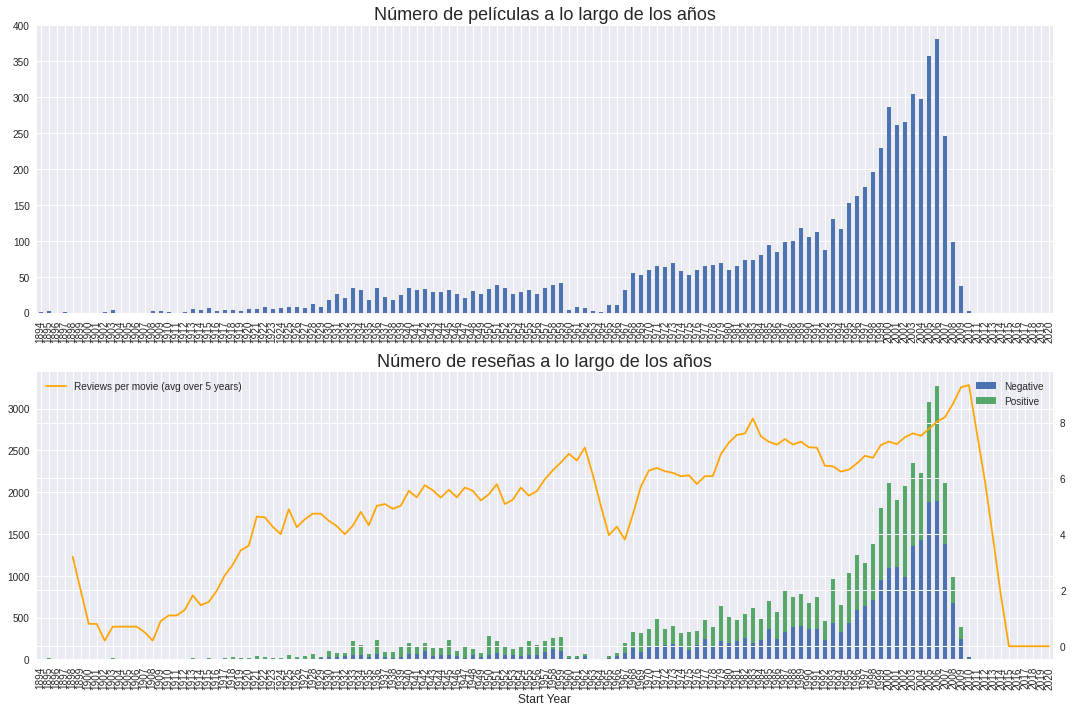

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años', fontsize=18)

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label=['neg', 'pos'], ax=ax)
axs[1].legend(labels=['Negative', 'Positive'], loc=0)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='Reviews per movie (avg over 5 years)', ax=axt)
axt.legend(loc=0)
ax.set_title('Número de reseñas a lo largo de los años', fontsize=18)
ax.set_xlabel('Start Year', fontsize=12)
fig.tight_layout()

Se observa a partir del primer gráfico que la cantidad de películas en general se incrementa con los años. No obstante, existe un período entre 1960 y 1966 en que la cantidad de películas disminuye drásticamente y luego se recupera. La tendencia es creciente hasta el año 2006, año a partir del cual la cantidad nuevamente baja. Mientras se puede decir que la caída desde el año 2006 puede deberse a que el dataset no está actualizado, para el caso del período de los años 60 no existen razones claras que puedan explicar la caída en el número de películas.

En el segundo gráfico, se puede observar que las reseñas positivas comparten proporciones similares con las reseñas negativas y no existe una predominancia clara de las unas sobre las otras en el tiempo. Por otro lado, se puede observar que el promedio de reseñas por película acompaña la tendencia de la cantidad de películas a lo largo de los años pero con un rango menor de variación en general.

### <a id='toc2_2_'></a>[Frecuencia de cantidad de reseñas por película](#toc0_)

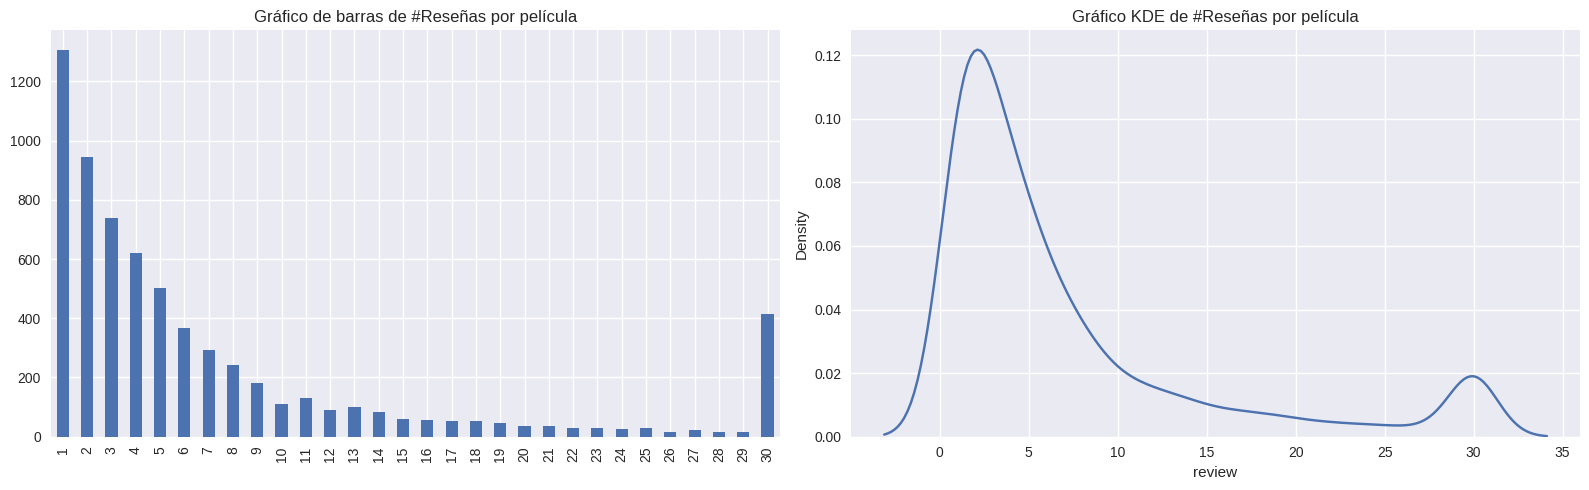

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Como es de esperar, es común que las películas tengan solo una reseña y que la frecuencia de la cantidad de reseñas disminuya a medida que aumenta el número de reseñas por película. Sin embargo, también existe un importante número de películas con 30 reseñas, lo cual podría corresponder a un error de registro o de otro tipo, aunque no se descarta que correspondan a películas altamente populares, las cuales acumulan un número excepcionalmente alto de reseñas.

### <a id='toc2_3_'></a>[Distribución de reseñas negativas y positivas en los conjuntos de entrenamiento y prueba](#toc0_)

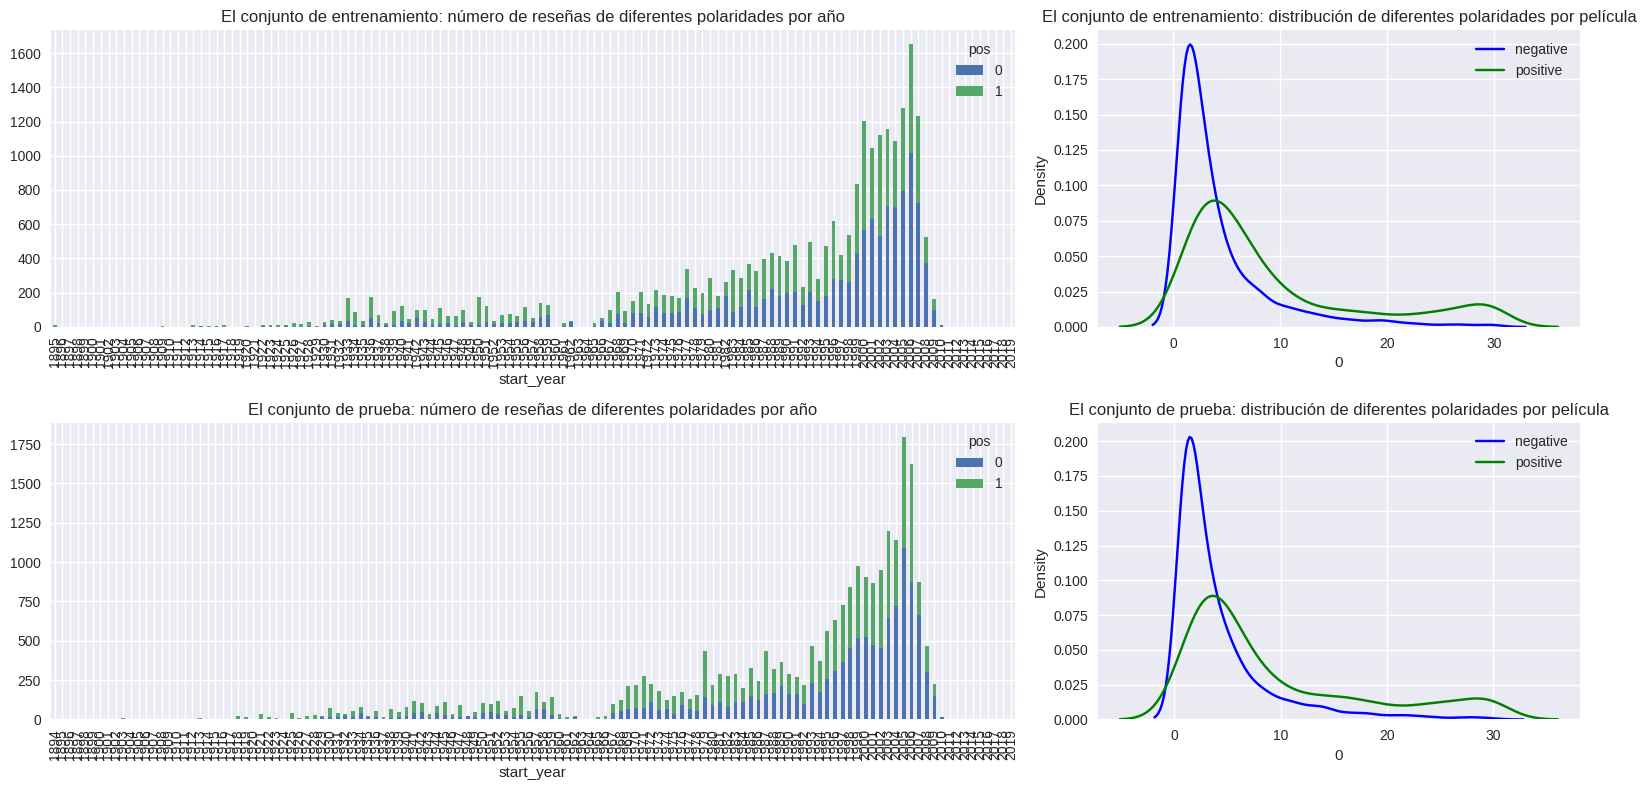

In [124]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Se observa una tendencia similar a la observada en la serie anterior tanto para el conjunto de entrenamiento como el de prueba. También, las distribuciones son similares en ambos conjuntos. Se destaca que existe predominancia de reseñas negativas sobre las positivas cuando la cantidad de reseñas por película es baja. Sin embargo, a medida que aumenta el número de reseñas, aunque la frecuencia disminuye, la proporción de reseñas positivas aumenta. Esto podría deberse a que las películas con más reseñas son más populares y por lo tanto, más atractivas para el público.

### <a id='toc2_4_'></a>[Equilibrio de clases](#toc0_)

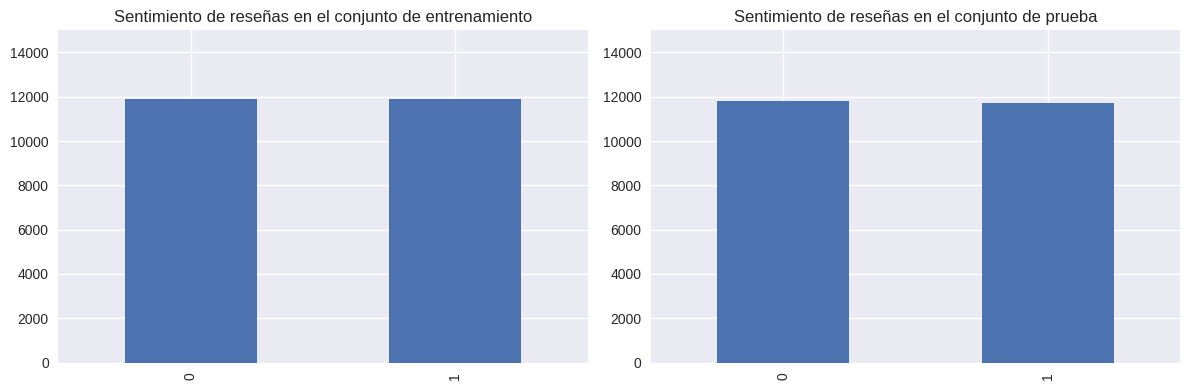

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['pos'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 3))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 15000])
ax.set_title('Sentimiento de reseñas en el conjunto de entrenamiento')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['pos'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 3))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 15000])
ax.set_title('Sentimiento de reseñas en el conjunto de prueba')

fig.tight_layout()

Tanto el conjunto de entrenamiento como el de prueba presentan una cantidad similar de reseñas positivas y negativas. Lo que indica que existe un equilibrio de clases.

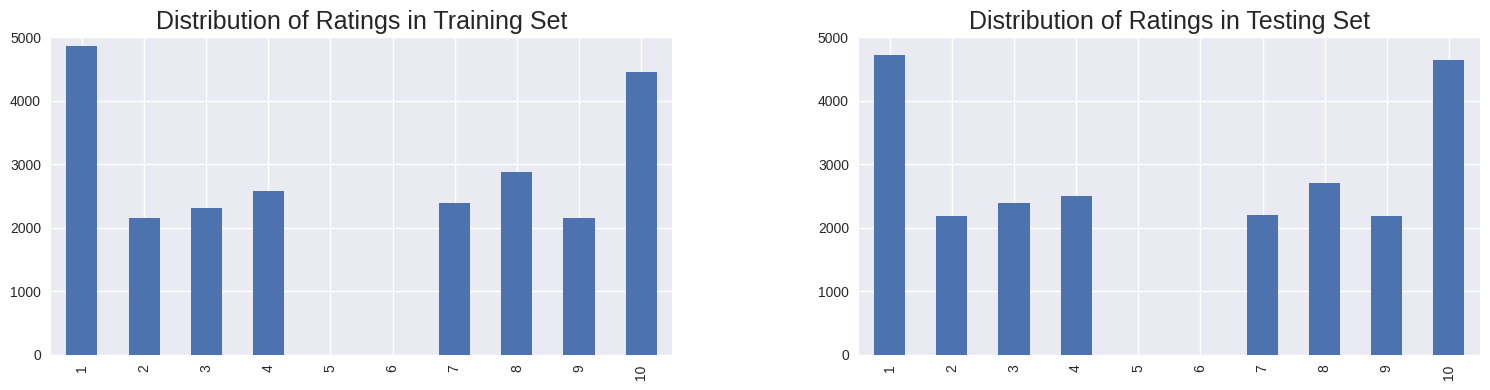

In [126]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

ax = axs[0]

dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Distribution of Ratings in Training Set', fontsize=18)

ax = axs[1]

dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Distribution of Ratings in Testing Set', fontsize=18)

fig.tight_layout()
fig.subplots_adjust(wspace=.3)
plt.show()

Adicionalmente, la distribución de los ratings de las películas indica frecuencias similares en los conjuntos de entrenamiento y prueba, siendo lo más común asignar un rating de 1 o 10 cuando la reseña es negativa o positiva, respectivamente. Cabe destacar que este conjunto de datos no considera ratings intermedios ya que no existen valores entre 5 y 6, esto es positivo para el análisis ya que se evita la ambigüedad en la clasificación de las reseñas.

## <a id='toc3_'></a>[Procedimiento de evaluación](#toc0_)

In [127]:

def evaluate_model(model, train_features, train_target, test_features, test_target):

    '''
    Esta función toma un modelo de clasificación y los conjuntos de datos de entrenamiento y prueba,
    y calcula y visualiza métricas de evaluación importantes, incluyendo F1, ROC AUC, APS, exactitud y curvas ROC y PRC.
    Los resultados se presentan en una figura con tres subgráficos y se imprimen en forma de tabla.
    Esto facilita la evaluación del rendimiento del modelo en diferentes conjuntos de datos y umbrales de probabilidad.

    '''

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## <a id='toc4_'></a>[Normalización](#toc0_)

Se preparan los datos al procesar el texto de las reseñas de modo que se elimina todo lo que no sean letras y apóstrofes. Además, se transforma todo el texto a minúsculas.

In [128]:
def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text).lower()
    return text

In [129]:
df_reviews['review_norm'] = df_reviews['review'].progress_apply(clear_text)

  0%|          | 0/47331 [00:00<?, ?it/s]

In [130]:
#Reseñas antes y después del procesamiento
print(df_reviews['review'].head())
print()
print(df_reviews['review_norm'].head())

0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
2    There is no real story the film seems more lik...
3    Um .... a serious film about troubled teens in...
4    I'm totally agree with GarryJohal from Singapo...
Name: review, dtype: object

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object


## <a id='toc5_'></a>[Generación de conjuntos de entrenamiento y prueba](#toc0_)

In [131]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#Caracteristicas y objetivos de entrenamiento
train_features=df_reviews_train['review_norm']
train_target = df_reviews_train['pos']

#Caracteristicas y objetivos de prueba
test_features=df_reviews_test['review_norm']
test_target = df_reviews_test['pos']

# Dimensiones de los conjuntos generados
print('train_features shape: ', train_features.shape)
print('train_target shape: ', train_target.shape)
print('test_features shape: ', test_features.shape)
print('test_target shape: ', test_target.shape)


train_features shape:  (23796,)
train_target shape:  (23796,)
test_features shape:  (23535,)
test_target shape:  (23535,)


## <a id='toc6_'></a>[Entrenamiento y evaluación de modelos](#toc0_)

### <a id='toc6_1_'></a>[Modelo 0 - Constante](#toc0_)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


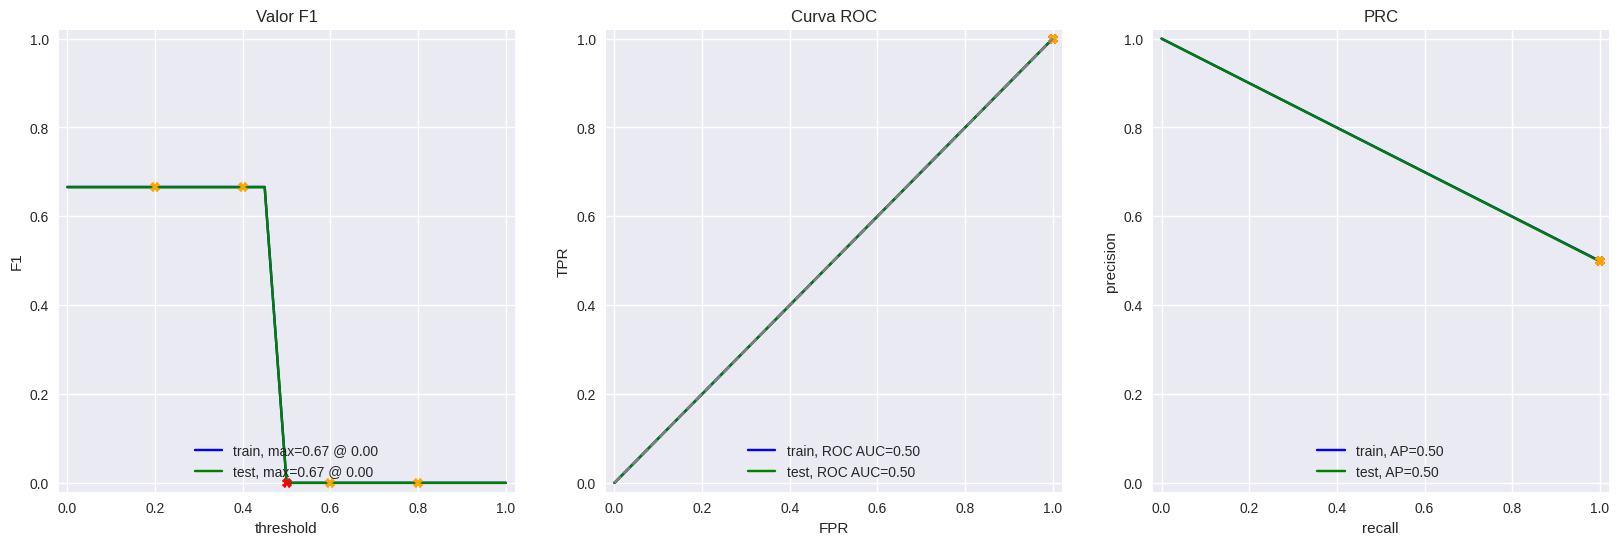

In [133]:
model_0 = DummyClassifier()
model_0.fit(train_features, train_target)
evaluate_model(model_0, train_features, train_target, test_features, test_target)

El modelo dummy predijo los valores correctos con una exactitud de 0.5 en ambos conjuntos. Las métricas de F1, APS y AUC-ROC también fueron de 0.5. Estos resultados indican un rendimiento que no es mejor que el azar.

### <a id='toc6_2_'></a>[Modelo 1 - NLTK, TF-IDF y LR](#toc0_)

In [135]:
stop_words = list(stopwords.words('english'))
model1_tf_idf = TfidfVectorizer(stop_words=stop_words)

train_features_tf_idf = model1_tf_idf.fit_transform(train_features)
test_features_tf_idf = model1_tf_idf.transform(test_features)

print('El tamaño de la matriz de entrenamiento TF-IDF:', train_features_tf_idf.shape)
print('El tamaño de la matriz de prueba TF-IDF:', test_features_tf_idf.shape)

El tamaño de la matriz de entrenamiento TF-IDF: (23796, 71531)
El tamaño de la matriz de prueba TF-IDF: (23535, 71531)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


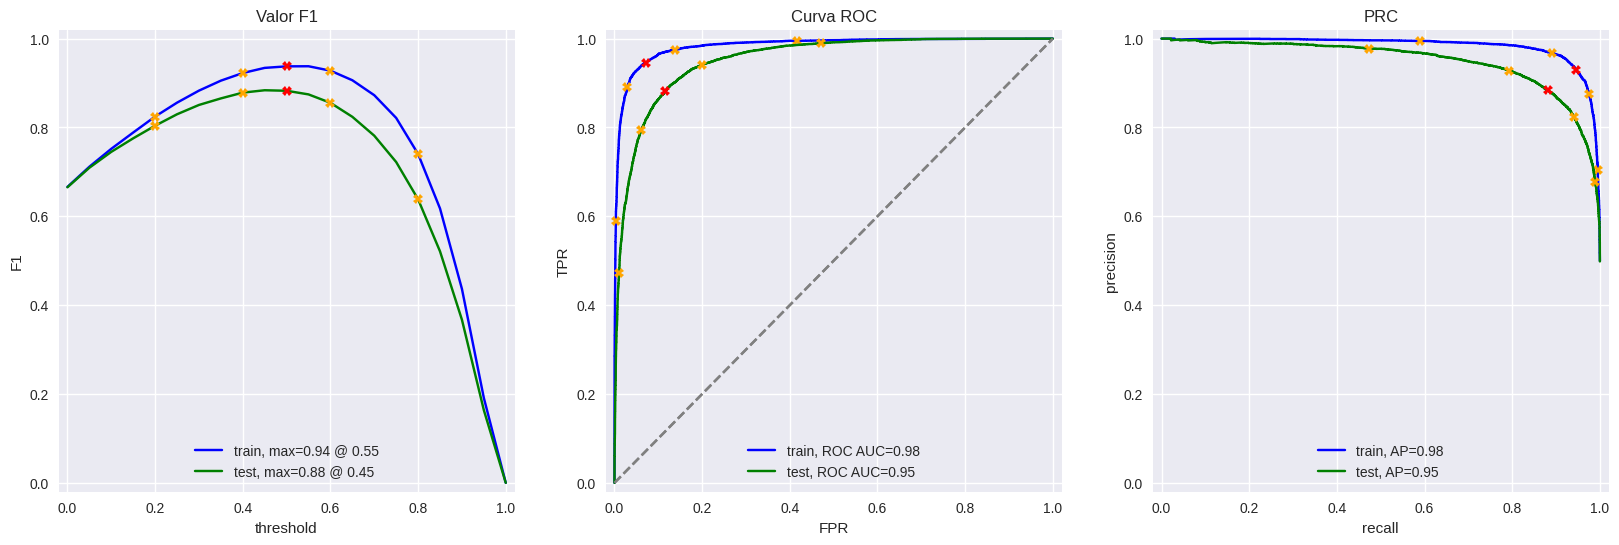

In [136]:
model_1 = LogisticRegression(random_state=0, solver='liblinear')
model_1.fit(train_features_tf_idf, train_target)
evaluate_model(model_1, train_features_tf_idf, train_target, test_features_tf_idf, test_target)

Los resultados indican un buen rendimiento del modelo de regresión logística en los conjuntos de entrenamiento y prueba. El modelo supera supera el rendimiento del modelo dummy y la métrica de F1 es mayor a 0.85 como es requerido por la compañia. Esto quiere decir que la transformación del texto a representaciones numéricas utilizando TF-IDF ofrece buenos resultados.

### <a id='toc6_3_'></a>[Modelo 2 - spaCy, TF-IDF y LR](#toc0_)

In [137]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = nlp.Defaults.stop_words

In [138]:
# Función para lematizar y omitir stopwords
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [139]:
# Aplicación de la función a las características de entrenamiento y prueba
train_features_lemma=train_features.progress_apply(text_preprocessing_3)
test_features_lemma=test_features.progress_apply(text_preprocessing_3)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [140]:
# Transformación de características de texto en matrices TF-IDF
stop_words = list(stopwords.words('english'))
model2_tf_idf = TfidfVectorizer(stop_words=stop_words)

train_features_tf_idf2 = model2_tf_idf.fit_transform(train_features_lemma)
test_features_tf_idf2 = model2_tf_idf.transform(test_features_lemma)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


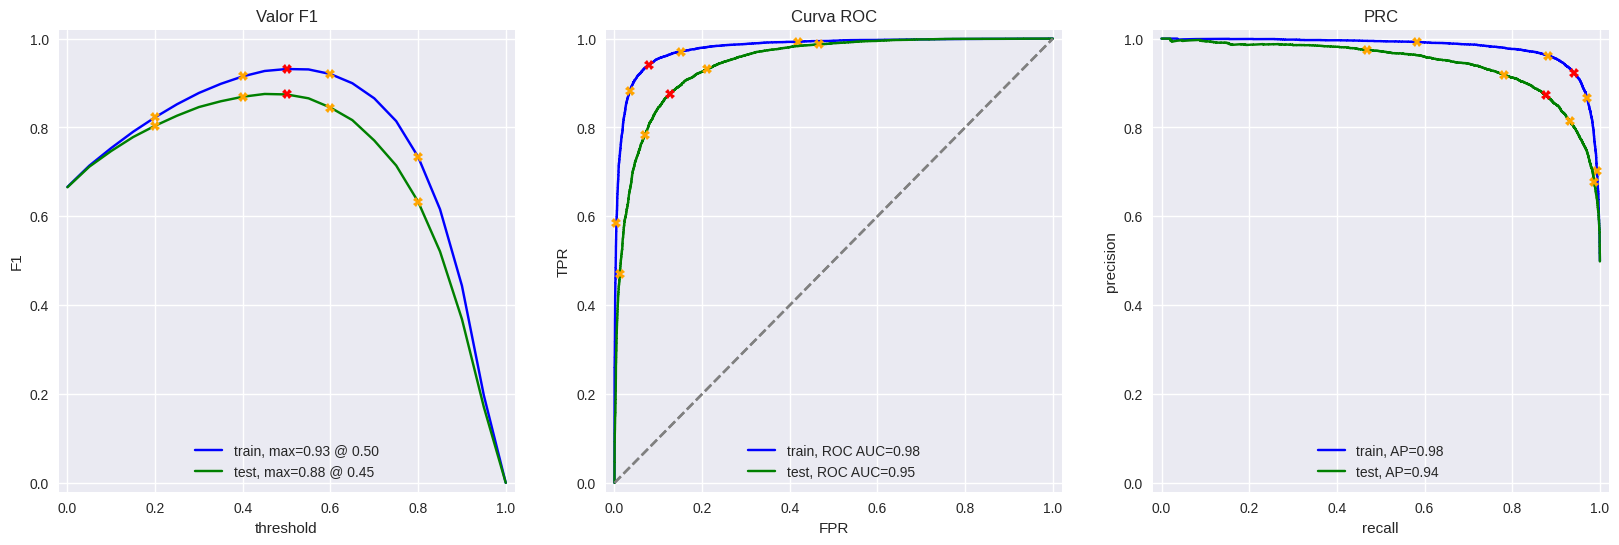

In [141]:
model_2 = LogisticRegression(random_state=0, solver='saga')
model_2.fit(train_features_tf_idf2, train_target)
evaluate_model(model_2, train_features_tf_idf2, train_target, test_features_tf_idf2, test_target)

Este modelo otorga un rendimiento similar al modelo anterior. No obstante, el tiempo para procesar el texto, que incluye lematizar las palabras y eliminar las stop-words, es mucho mayor que el tiempo requerido por el modelo anterior. Aunque la métrica de F1 está por encima del 0.85 requerido, esta opción podría resultar menos práctica que la anterior dependiendo de la capacidad de cómputo disponible.

### <a id='toc6_4_'></a>[Modelo 3 - spaCy, TF-IDF y LGBMClassifier](#toc0_)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.035977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430759
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


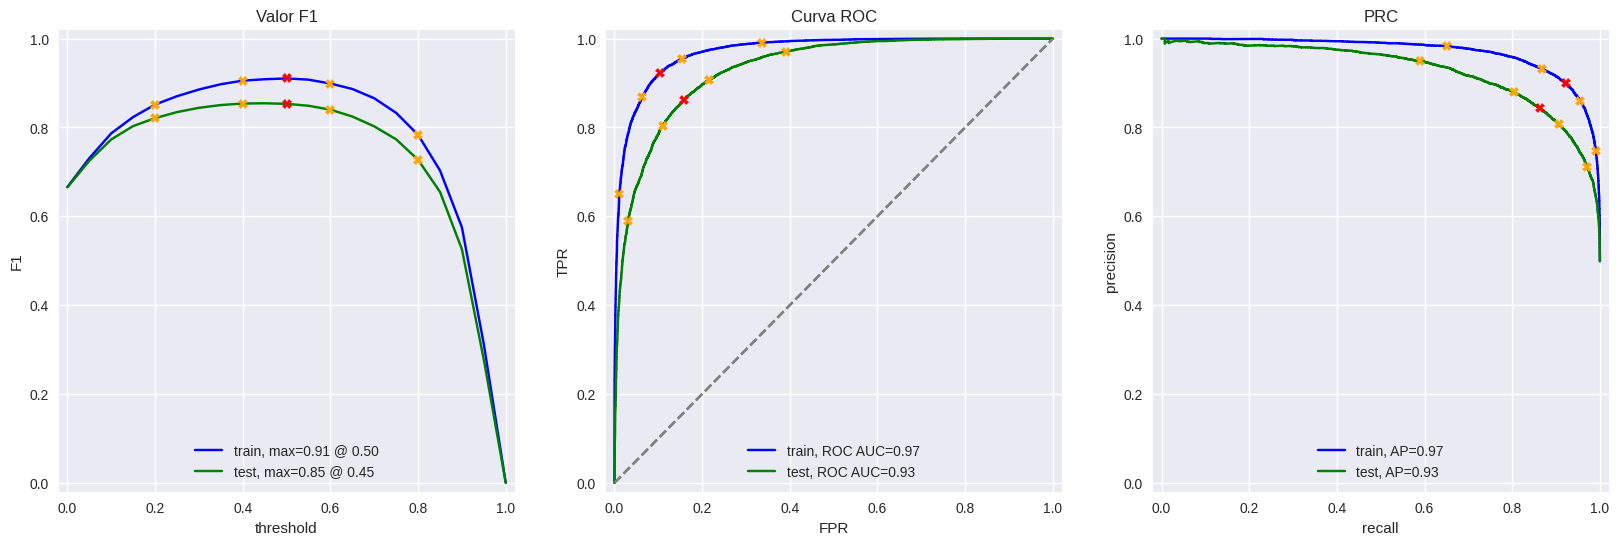

In [143]:
model_3 = LGBMClassifier(random_state=0)
model_3.fit(train_features_tf_idf2, train_target)
evaluate_model(model_3, train_features_tf_idf2, train_target, test_features_tf_idf2, test_target)

El rendimiento es ligeramente menor con respecto a los modelos anteriores, sin embargo, aún supera el valor de F1 requerido. Por otro lado, la ejecución del modelo tardó mucho menos tiempo que el modelo anterior.

### <a id='toc6_5_'></a>[ Modelo 4 - BERT](#toc0_)

In [145]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [146]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención

    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)



    # <escribe tu código aquí para crear ids_list y attention_mask_list>

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # Creamos attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [147]:
try:
    #Try to load embedded data from locally saved file.
    with np.load('/content/drive/MyDrive/Colab Notebooks/datasets/features_bert.npz') as data:
        train_features_BERT = data['train_features']
        test_features_BERT = data['test_features']
except:
    #Obtain embeddings for training and testing sets.
    train_features_BERT = BERT_text_to_embeddings(train_features)
    test_features_BERT = BERT_text_to_embeddings(test_features)

    #Save embeddings for future use.
    np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/datasets/features_bert.npz', train_features=train_features_BERT, test_features=test_features_BERT)


In [148]:
# Dimensiones de los conjuntos
print(train_features.shape)
print(train_features_BERT.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


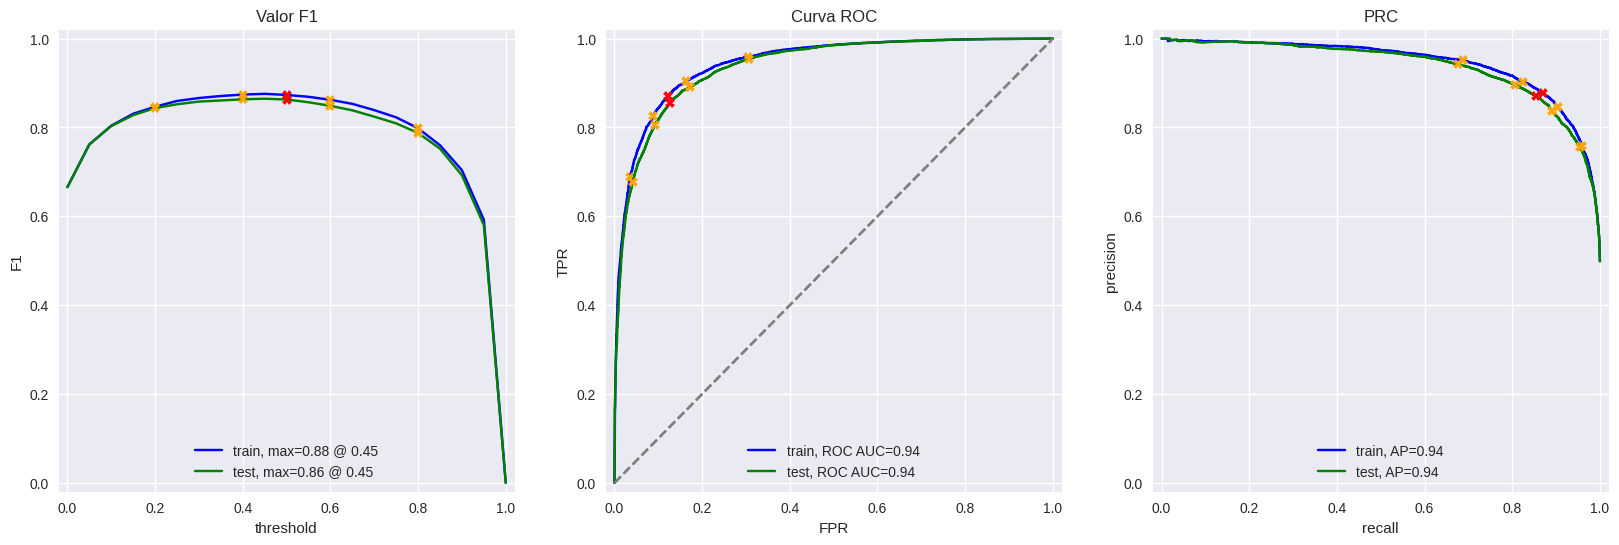

In [149]:
model_4 = LogisticRegression()

model_4.fit(train_features_BERT, train_target)

evaluate_model(model_4, train_features_BERT, train_target, test_features_BERT, test_target)

El modelo de regresión logística con BERT otorga una menor diferencia entre las métricas del conjunto de entrenamiento y el prueba, por lo que la capacidad de generalización es mayor con respecto a los modelos con NLTK y spaCy, sin embargo, el tiempo de ejecución de BERT es significativamente mayor, haciendo que el uso de este modelo pueda ser poco práctico dependiendo de la capacidad de cómputo disponible.

## <a id='toc7_'></a>[Evaluación de modelos con nuevas reseñas](#toc0_)

En esta sección se evalúan los modelos entrenados previamente con un nuevo grupo de reseñas para comprobar su rendimiento. Para ello, se procesará el texto del nuevo grupo con los métodos usados para cada modelo y se buscará obtener las probablidades predichas para cada clase, redondeando su valor para conocer la clase asignada por el modelo.

In [150]:
# Nuevo grupo de reseñas

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    # Reseñas adicionales añadidas
    "I absolutely loved this movie! The storyline was gripping, and the performances were top-notch. A must-see!",
    "What a disappointment. I had high hopes, but the movie fell flat. Boring plot and wooden acting.",
    "This film was a pleasant surprise. I didn't expect much, but it turned out to be a hidden gem.",
    "I couldn't stop laughing throughout the entire film. Hilarious from start to finish!"
], columns=['review'])

# Sentimiento para cada reseña
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
# Procesamiento para eliminar todo lo que no sean letras y apóstrofes, y transformar a minúsculas
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews

,review,pos,review_norm
0,"I did not simply like it, not my kind of movie.",0,i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",0,well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,1,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,0,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,1,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",1,the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,0,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,1,launching on netflix was a brave move i really...
8,I absolutely loved this movie! The storyline w...,1,i absolutely loved this movie the storyline wa...
9,"What a disappointment. I had high hopes, but t...",0,what a disappointment i had high hopes but the...


### <a id='toc7_1_'></a>[Modelo 1 - NLTK, TF-IDF y LR](#toc0_)

In [151]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(model1_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review}')

Actual: 0 | Predicted: 0 | Text: i did not simply like it not my kind of movie
Actual: 0 | Predicted: 0 | Text: well i was bored and felt asleep in the middle of the movie
Actual: 1 | Predicted: 1 | Text: i was really fascinated with the movie
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
Actual: 1 | Predicted: 0 | Text: i didn't expect the reboot to be so good writers really cared about the source material
Actual: 1 | Predicted: 0 | Text: the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
Actual: 0 | Predicted: 0 | Text: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
Actual: 1 | Predicted: 1 | Text: launching on netflix was a brave move i really appreciate being able to binge on episode after episo
Actual: 1 | Predicted: 1 | Text: i absolutely loved this movie the storyline was gripping and the p

Para las nuevas reseñas, el modelo predijo el sentimiento correctamente para 10 de los 12 textos. Las filas que no se predijeron correctamente son las 5 y 6, las cuales se asocian son sentimientos positivos.

### <a id='toc7_2_'></a>[Modelo 2 - spaCy, TF-IDF y LR](#toc0_)

In [152]:
texts = my_reviews['review_norm'].apply(text_preprocessing_3)
my_reviews_pred_prob = model_2.predict_proba(model2_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review}')

Actual: 0 | Predicted: 0 | Text: simply like kind movie
Actual: 0 | Predicted: 0 | Text: bored feel asleep middle movie
Actual: 1 | Predicted: 1 | Text: fascinated movie
Actual: 0 | Predicted: 0 | Text: actor look old disintereste get pay movie soulless cash grab
Actual: 1 | Predicted: 0 | Text: expect reboot good writer care source material
Actual: 1 | Predicted: 0 | Text: movie upside downside feel like overall decent flick go
Actual: 0 | Predicted: 0 | Text: rotten attempt comedy single joke land act annoying loud kid will like
Actual: 1 | Predicted: 1 | Text: launch netflix brave appreciate able binge episode episode exciting intelligent new drama
Actual: 1 | Predicted: 1 | Text: absolutely love movie storyline grip performance notch
Actual: 0 | Predicted: 0 | Text: disappointment high hope movie fall flat boring plot wooden acting
Actual: 1 | Predicted: 1 | Text: film pleasant surprise expect turn hidden gem
Actual: 1 | Predicted: 1 | Text: stop laugh entire film hilarious start f

Como en el modelo anterior, este modelo predijo correctamente 10 de 12 textos y nuevamente las filas 5 y 6 se predijeron de forma incorrecta.

### <a id='toc7_3_'></a>[Modelo 3 - spaCy, TF-IDF y LGBMClassifier](#toc0_)

In [153]:
texts = my_reviews['review_norm'].apply(text_preprocessing_3)

model3_tf_idf = model2_tf_idf
my_reviews_pred_prob = model_3.predict_proba(model3_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review}')

Actual: 0 | Predicted: 1 | Text: simply like kind movie
Actual: 0 | Predicted: 0 | Text: bored feel asleep middle movie
Actual: 1 | Predicted: 1 | Text: fascinated movie
Actual: 0 | Predicted: 0 | Text: actor look old disintereste get pay movie soulless cash grab
Actual: 1 | Predicted: 1 | Text: expect reboot good writer care source material
Actual: 1 | Predicted: 0 | Text: movie upside downside feel like overall decent flick go
Actual: 0 | Predicted: 0 | Text: rotten attempt comedy single joke land act annoying loud kid will like
Actual: 1 | Predicted: 1 | Text: launch netflix brave appreciate able binge episode episode exciting intelligent new drama
Actual: 1 | Predicted: 1 | Text: absolutely love movie storyline grip performance notch
Actual: 0 | Predicted: 0 | Text: disappointment high hope movie fall flat boring plot wooden acting
Actual: 1 | Predicted: 1 | Text: film pleasant surprise expect turn hidden gem
Actual: 1 | Predicted: 1 | Text: stop laugh entire film hilarious start f

Se predicen correctamente 10 de los 12 textos. A diferencia de los modelos anteriores, las filas que no se predijeron correctamente son la 1 y la 6. La reseña de la fila 1, en este caso, se asocia con sentimientos negativos.

### <a id='toc7_4_'></a>[Modelo 4 - BERT](#toc0_)

In [154]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review}')

Actual: 0 | Predicted: 0 | Text: i did not simply like it not my kind of movie
Actual: 0 | Predicted: 0 | Text: well i was bored and felt asleep in the middle of the movie
Actual: 1 | Predicted: 1 | Text: i was really fascinated with the movie
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
Actual: 1 | Predicted: 0 | Text: i didn't expect the reboot to be so good writers really cared about the source material
Actual: 1 | Predicted: 1 | Text: the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
Actual: 0 | Predicted: 0 | Text: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
Actual: 1 | Predicted: 1 | Text: launching on netflix was a brave move i really appreciate being able to binge on episode after episo
Actual: 1 | Predicted: 1 | Text: i absolutely loved this movie the storyline was gripping and the p

Este modelo predijo únicamente un texto de forma incorrecta, el cual corresponde a la fila 5. Esta reseña contiene la palabra "good" la cual puede asociarse a sentimientos positivos, sin embargo, el modelo la clasificó erróneamente.

## <a id='toc8_'></a>[Conclusiones](#toc0_)

Este proyecto tuvo como objetivo entrenar un modelo para detectar reseñas positivas y negativas de forma automática con un F1 no menor a 0.85. Para ello se procesó un conjunto de datos de reseñas de películas de IMBD y se puso a prueba distintos modelos.

Los conjuntos de entrenamiento y prueba presentaron un equilibro de clases y una distribución polarizada en los ratings de las películas, lo que es beneficioso para el análisis ya que se evita la ambigüedad en la clasificación de las reseñas.

Las reseñas del conjunto de datos fueron previamente procesadas con el fin de adecuarlas al formato requerido para cada modelo, lo cual incluyó eliminar signos de puntuación, vectorización con TF-IDF, lematización y tokenización con spaCy y transformación a representaciones numéricas mediante embeddings con BERT.

En el entrenamiento y evaluación de los modelos, se encontró que todos los modelos superaron la prueba de cordura al tener un rendimiento mejor que el modelo Dummy y, adicionalmente, todos obtuvieron un F1 superior al requerido. Las principales diferencias se observaron en el tiempo de ejecución, donde el modelo 2 con spaCy, TF-IDF y LR y el modelo 4 con BERT fueron los que más tardaron en ejecutarse. Debido a esto, se recomienda el uso del modelo 1 con NLTK, TF-IDF y LR por ser el de mayor F1 y tener un tiempo de ejecución corto.

Finalmente, se evaluaron los distintos modelos con un grupo de doce nuevas reseñas. Tras realizar el mismo procesamiento que al inicio, se encontró que las predicciones realizadas por los modelos acertaron entre el 83 y 90% de las veces, siendo el modelo con Bert el que tuvo la mayor exactitud. Estos resultados son consistentes con las métricas observadas en la sección de entrenamiento y evaluación.